In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Multiply, Input, Concatenate


In [2]:
train_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/training_set"
test_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/test_set"

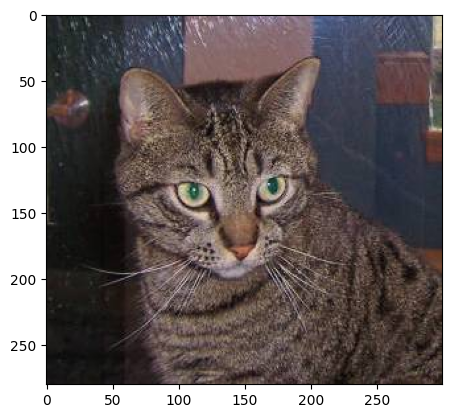

In [3]:
img = cv2.imread(train_path + "/cat/cat.1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.imshow(img)

In [4]:
# ImageDataGenerator to apply data augmentation, randomly translating, rotating, resizing, etc.
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen.fill_mode='constant'
train_datagen.horizontal_flip=True
train_datagen.zoom_range=[0.8, 1.2]
train_datagen.rotation_range=20
train_datagen.shear_range=10
train_datagen.brightness_range = [0.75, 1.5]



#making image as 227X227 for input of alexnet
# train = train_datagen.flow_from_directory(train_path, target_size=(227,227), class_mode='categorical')
train = train_datagen.flow_from_directory(train_path, target_size=(64, 64), shuffle=True, class_mode='categorical')


Found 4000 images belonging to 2 classes.


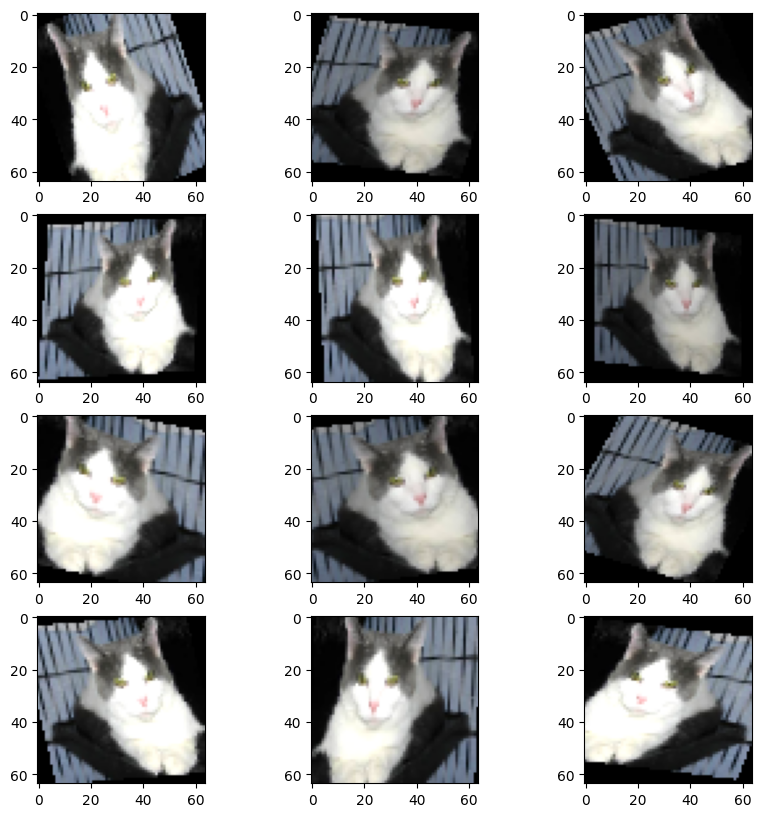

In [5]:
fig , axs = plt.subplots(4,3 ,figsize = (10,10))

axs[0][0].imshow(train[1][0][0])
axs[0][1].imshow(train[1][0][0])
axs[0][2].imshow(train[1][0][0])
axs[1][0].imshow(train[1][0][0])
axs[1][1].imshow(train[1][0][0])
axs[1][2].imshow(train[1][0][0])
axs[2][0].imshow(train[1][0][0])
axs[2][1].imshow(train[1][0][0])
axs[2][2].imshow(train[1][0][0])
axs[3][0].imshow(train[1][0][0])
axs[3][1].imshow(train[1][0][0])
axs[3][2].imshow(train[1][0][0])

In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test = test_datagen.flow_from_directory(test_path, target_size=(64,64), shuffle=False, class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [22]:
def squeeze_excite_block(X, ratio=0.25):
    # Squeeze: Global Average Pooling
    se_shape = (1, 1, X.shape[-1])
    se = GlobalAveragePooling2D()(X)
    se = tf.keras.layers.Reshape(se_shape)(se)
    
    # Excitation: Fully Connected Layer + Sigmoid Activation
    se = Dense(X.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1] , activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    # Recalibration
    X = Multiply()([X, se])
    return X


def SimpleSENet(input_shape=(224, 224, 3), classes=10):
    X_input = Input(shape=input_shape)

    # Initial Convolution Layer
    X = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # SE Block 1
    X = Conv2D(64, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # SE Block 2
    X = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # SE Block 3
    X = Conv2D(256, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # Global Average Pooling and Fully Connected Layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name='SimpleSENet')

    return model


# Initialize the model
network = SimpleSENet(input_shape=(64, 64, 3), classes=2)

network.summary()


Model: "SimpleSENet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_48 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │     18,496 │ re_lu_48[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_49 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_49[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_36          │ (None, 1, 1, 64)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 1, 1, 16)  │      1,024 │ reshape_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 1, 1, 64)  │      1,024 │ dense_84[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 1, 1, 64)  │      4,096 │ dense_85[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_36         │ (None, 32, 32,    │          0 │ re_lu_49[0][0],   │
│ (Multiply)          │ 64)               │            │ dense_86[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 16, 16,    │     73,856 │ multiply_36[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_37          │ (None, 1, 1, 128) │          0 │ global_average_p

 Total params: 519,874 (1.98 MB)

 Trainable params: 518,914 (1.98 MB)

 Non-trainable params: 960 (3.75 KB)

In [41]:
def squeeze_excite_block(X, ratio=0.25):
    # Squeeze: Global Average Pooling
    se_shape = (1, 1, X.shape[-1])
    se = GlobalAveragePooling2D()(X)
    se = tf.keras.layers.Reshape(se_shape)(se)
    
    # Excitation: Fully Connected Layer + Sigmoid Activation
    se = Dense(X.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1] , activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    # Recalibration
    X = Multiply()([X, se])
    return X


def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    # 3x3 convolution branch
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3_1 = Conv2D(filters_3x3, (1, 3), padding='same', activation='relu')(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3, (3, 1), padding='same', activation='relu')(conv_3x3)
    
    # 5x5 convolution branch
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu')(conv_5x5)
    conv_5x5_1 = Conv2D(filters_5x5, (1, 3), padding='same', activation='relu')(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5, (3, 1), padding='same', activation='relu')(conv_5x5)
    
    # Pooling branch
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # SE branch 1 
    se_block1 = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    se_block1 = BatchNormalization()(se_block1)
    se_block1 = ReLU()(se_block1)
    se_block1 = squeeze_excite_block(se_block1, ratio=4)

    # SE branch 2
    se_block2 = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    se_block2 = BatchNormalization()(se_block2)
    se_block2 = ReLU()(se_block2)
    se_block2 = squeeze_excite_block(se_block2, ratio=4)

    
    # Concatenate all branches
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3_1, conv_3x3_2, conv_5x5_1, conv_5x5_2, pool_proj, se_block1, se_block2])
    
    return output


def SimpleSENet_Inception(input_shape=(224, 224, 3), classes=10):
    X_input = Input(shape=input_shape)

    # Initial Convolution Layer
    X = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # Inception Block 1
    X = inception_module(X, 16, 64, 128, 16, 32, 32)

    # SE Block 1
    X = Conv2D(64, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # Inception Block 2
    X = inception_module(X, 64, 64, 192, 32, 96, 64)

    # SE Block 3
    X = Conv2D(256, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    X = Dropout(0.2)(X)

    # Global Average Pooling and Fully Connected Layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name='SimpleSENet_Inception')

    return model


# Initialize the model
network = SimpleSENet_Inception(input_shape=(64, 64, 3), classes=2)

network.summary()


Model: "SimpleSENet_Inception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_64 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │     36,992 │ re_lu_64[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │     36,992 │ re_lu_64[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_65 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_66 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_65[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_66[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_48          │ (None, 1, 1, 128) │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_49          │ (None, 1, 1, 128) │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 1, 1, 32)  │      4,096 │ reshape_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_127 (Dense)   │ (None, 1, 1, 32)  │      4,096 │ reshape_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32,    │        528 │ re_lu_64[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,237,282 (12.35 MB)

 Trainable params: 3,235,554 (12.34 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
def squeeze_excite_block(X, ratio=0.25):
    # Squeeze: Global Average Pooling
    se_shape = (1, 1, X.shape[-1])
    se = GlobalAveragePooling2D()(X)
    se = tf.keras.layers.Reshape(se_shape)(se)
    
    # Excitation: Fully Connected Layer + Sigmoid Activation
    se = Dense(X.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    # Recalibration
    X = Multiply()([X, se])
    return X


def residual_block(X, filters):
    shortcut = X

    # First component of the main path, SE Block
    X = squeeze_excite_block(X, ratio=4)

    # Add shortcut to the main path
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X


def SimpleSENet_ResNet(input_shape=(224, 224, 3), classes=10):
    X_input = Input(shape=input_shape)

    # Initial Convolution Layer
    X = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # SE Block 1
    X = Conv2D(64, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # Residual Block 1
    X = residual_block(X, filters=64)

    # SE Block 2
    X = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # Residual Block 2
    X = residual_block(X, filters=128)

    # SE Block 3
    X = Conv2D(256, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # Global Average Pooling and Fully Connected Layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name='SimpleSENet_ResNet')

    return model


# Initialize the model
network = SimpleSENet(input_shape=(64, 64, 3), classes=2)

network.summary()


In [ ]:
def squeeze_excite_block(X, ratio=0.25):
    # Squeeze: Global Average Pooling
    se_shape = (1, 1, X.shape[-1])
    se = GlobalAveragePooling2D()(X)
    se = tf.keras.layers.Reshape(se_shape)(se)
    
    # Excitation: Fully Connected Layer + Sigmoid Activation
    se = Dense(X.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1] , activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(X.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    # Recalibration
    X = Multiply()([X, se])
    return X


def resnext_block(X, filters, cardinality, strides=1):
    group_list = []

    # Split the input into multiple groups
    for i in range(cardinality):

        group = Conv2D(filters // cardinality, kernel_size=(1, 1), strides=strides, padding='same')(X)
        group = BatchNormalization()(group)
        group = Activation('relu')(group)

        group = Conv2D(filters // cardinality, kernel_size=(3, 3), padding='same')(group)
        group = BatchNormalization()(group)
        group = Activation('relu')(group)

        group = Conv2D(filters, kernel_size=(1, 1), padding='same')(group)
        group = BatchNormalization()(group)
        
        group = squeeze_excite_block(group, ratio=4)
        group = BatchNormalization()(group)

        group_list.append(group)

    # Merge groups
    if len(group_list) > 1:
        X = Add()(group_list)
    else:
        X = group_list[0]

    # Shortcut path
    shortcut = X

    # Add shortcut to the main path
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X


def SimpleSENet_ResNeXt(input_shape=(224, 224, 3), classes=10, cardinality=8):
    X_input = Input(shape=input_shape)

    # Initial Convolution Layer
    X = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = ReLU()(X)

    # SE Block 1
    X = Conv2D(64, kernel_size=(3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # SE Block 2
    X = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = squeeze_excite_block(X, ratio=4)

    # ResNeXt Block 1
    X = resnext_block(X, filters=128, cardinality=cardinality, strides=1)
    
    # ResNeXt Block 2
    X = resnext_block(X, filters=256, cardinality=cardinality, strides=2)

    X = Dropout(0.2)(X)

    # Global Average Pooling and Fully Connected Layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name='SimpleSENet_ResNeXt')

    return model


# Initialize the model
network = SimpleSENet(input_shape=(64, 64, 3), classes=2)

network.summary()


In [42]:
# Define the learning rate you want to use
learning_rate = 0.0001  # Example learning rate

# Instantiate the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile your neural network model with the customized optimizer
network.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history = network.fit(train, epochs=20)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 720ms/step - accuracy: 0.5826 - loss: 0.6804
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 740ms/step - accuracy: 0.6434 - loss: 0.6200
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 724ms/step - accuracy: 0.6688 - loss: 0.6079
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 733ms/step - accuracy: 0.6840 - loss: 0.5920
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 716ms/step - accuracy: 0.6794 - loss: 0.5854
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 713ms/step - accuracy: 0.7103 - loss: 0.5559
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 712ms/step - accuracy: 0.7170 - loss: 0.5545
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 707ms/step - accuracy: 0.7135 - loss: 0.5473
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 706ms/step - accuracy: 0.7389 - loss: 0.5199
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 702ms/step - accuracy: 0.7686 - loss: 0.4872
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 702ms/step - accuracy: 0.7391 - loss: 0.5166
Epoch 12/20
125/125

In [44]:
predictions = network.predict(test)
predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step


array([[0.5950724 , 0.40492767],
       [0.00452658, 0.99547344],
       [0.05299579, 0.94700426],
       ...,
       [0.00277642, 0.9972236 ],
       [0.01235394, 0.98764604],
       [0.00408276, 0.99591726]], dtype=float32)

In [45]:
# predicted values
predictions = np.argmax(predictions, axis=1)
predictions 

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

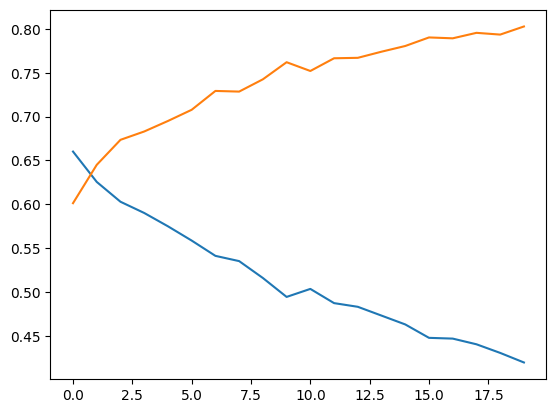

In [46]:
plt.plot(history.history['loss'] )
plt.plot(history.history['accuracy'] )

In [47]:
from sklearn.metrics import accuracy_score

accuracy_score(test.classes, predictions)

0.566